2023-09-19 21:12:14.856598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
459/459 - 1s - loss: 0.0066 - 1s/epoch - 2ms/step
Epoch 2/10
459/459 - 0s - loss: 0.0033 - 386ms/epoch - 840us/step
Epoch 3/10
459/459 - 0s - loss: 0.0036 - 349ms/epoch - 761us/step
Epoch 4/10
459/459 - 0s - loss: 0.0033 - 388ms/epoch - 846us/step
Epoch 5/10
459/459 - 0s - loss: 0.0033 - 356ms/epoch - 776us/step
Epoch 6/10
459/459 - 0s - loss: 0.0032 - 355ms/epoch - 774us/step
Epoch 7/10
459/459 - 0s - loss: 0.0032 - 349ms/epoch - 761us/step
Epoch 8/10
459/459 - 0s - loss: 0.0031 - 348ms/epoch - 759us/step
Epoch 9/10
459/459 - 0s - loss: 0.0031 - 349ms/epoch - 761us/step
Epoch 10/10
459/459 - 0s - loss: 0.0030 - 345ms/epoch - 752us/step
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


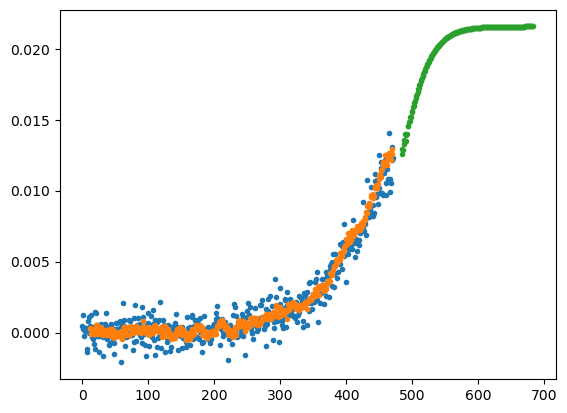

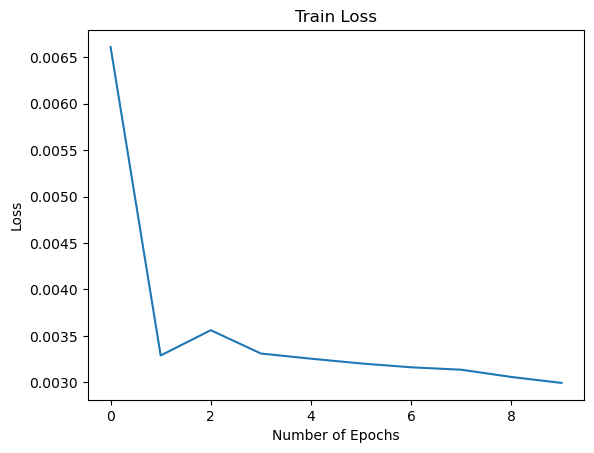

In [1]:
# LSTM for experiment O2 M0 with regression framing
import numpy as np
import os, random
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# convert an array of values into a dataset matrix
def create_dataset(inputdata, look_back):
    dataX, dataY = [], []
    for i in range(len(inputdata)-look_back-1):
        a = inputdata[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(inputdata[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)
   
# load the dataset
dataframe = read_csv('Exp_o2_m0_1000p_50%.csv', usecols=[0], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and predict size
# train_size = int(len(dataset) * 0.50) # *******
# predict_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train = dataset

# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
#testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# fix random seed for reproducibility
reset_random_seeds()

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#result = model.fit(trainX, trainY, epochs=10, validation_data=(testX, testY), batch_size=1, verbose=2) # *******
result = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2) # *******

# make train prediction
trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

# Predict future data
predictX = []
firstBatch = train[-look_back:]  # look_back = 4
currentBatch = firstBatch.reshape(1, 1, look_back)

futurePulses = 200 # predict 500 future pulses M0
for j in range(futurePulses):
    pred = model.predict(currentBatch)
    predictX.append(pred)
    currentBatch = np.append(currentBatch[:, :, 1:],[pred], axis=2)

futurePredict_arr = np.array(predictX)
futurePredict = np.reshape(futurePredict_arr, (futurePredict_arr.shape[0], -1))

plt.plot(scaler.inverse_transform(dataset), '.')
plt.plot(range(look_back,len(trainPredict)+look_back), scaler.inverse_transform(trainPredict), '.')
plt.plot(range(len(trainPredict)+(look_back*2)+1,len(dataset)+futurePulses+look_back),scaler.inverse_transform(futurePredict), '.')
plt.show()

plt.plot(result.history['loss'])
#plt.plot(result.history['val_loss'])
plt.title('Train Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
# plt.legend(['Train']) #, 'Validation'])
plt.show()